In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import time

***DataPreprocessing***

In [2]:
from google.colab import drive
# 授權連接到你的 Google Drive
drive.mount('/content/drive')

# 指定檔案的路徑
file_path = '/content/drive/MyDrive/Colab Notebooks/lfd_2023_group8.csv'

df = pd.read_csv(file_path)

df

Mounted at /content/drive


,grams,width_cm,frequency,location,price,flexibility,moisture,horizontal_position,shape,distance,target
0,490,137,594,Belgium,1607,65.27,34.27,-33.31,other,53.94,widget3
1,528,229,364,Belgium,805,40.99,57.65,-38.68,oblong,28.20,widget7
2,486,70,399,NaN,682,52.59,35.32,-21.66,spherical,45.66,widget1
3,542,112,437,Italy,808,47.25,79.57,105.93,oblong,49.13,widget1
4,522,202,411,India,1066,92.50,39.55,89.33,oblong,32.72,widget2
...,...,...,...,...,...,...,...,...,...,...,...
4995,434,230,301,Belgium,458,63.57,45.20,88.52,oblong,25.21,widget2
4996,296,121,549,NaN,859,38.36,45.30,-102.55,cylinder,21.39,widget5
4997,405,147,408,Japan,452,24.92,38.86,106.37,cylinder,33.87,widget8
4998,369,167,417,China,693,80.76,62.42,60.03,oblong,15.10,widget2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   grams                5000 non-null   int64  
 1   width_cm             5000 non-null   int64  
 2   frequency            5000 non-null   int64  
 3   location             4733 non-null   object 
 4   price                5000 non-null   int64  
 5   flexibility          5000 non-null   float64
 6   moisture             5000 non-null   float64
 7   horizontal_position  5000 non-null   float64
 8   shape                5000 non-null   object 
 9   distance             5000 non-null   float64
 10  target               5000 non-null   object 
dtypes: float64(4), int64(4), object(3)
memory usage: 429.8+ KB


__Handling missing values__

In [3]:
# Find the mode of the 'location' column for each target class
modes_by_target = df.groupby('target')['location'].agg(lambda x: x.mode().iloc[0])

# Fill missing values for each target class
for target_value, mode_value in modes_by_target.items():
    # Check for missing values in the target class
    if df[df['target'] == target_value]['location'].isnull().any():
        # Get the indices corresponding to the target class
        idx = (df['target'] == target_value) & df['location'].isnull()
        # Create SimpleImputer
        imputer = SimpleImputer(strategy='constant', fill_value=mode_value)
         # Fill missing values with the mode for the respective class
        df.loc[idx, 'location'] = imputer.fit_transform(df.loc[idx, ['location']])

In [ ]:
print(df.isna().sum())

grams                  0
width_cm               0
frequency              0
location               0
price                  0
flexibility            0
moisture               0
horizontal_position    0
shape                  0
distance               0
target                 0
dtype: int64


__Handling categorical values__

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   grams                5000 non-null   int64  
 1   width_cm             5000 non-null   int64  
 2   frequency            5000 non-null   int64  
 3   location             5000 non-null   object 
 4   price                5000 non-null   int64  
 5   flexibility          5000 non-null   float64
 6   moisture             5000 non-null   float64
 7   horizontal_position  5000 non-null   float64
 8   shape                5000 non-null   object 
 9   distance             5000 non-null   float64
 10  target               5000 non-null   object 
dtypes: float64(4), int64(4), object(3)
memory usage: 429.8+ KB


In [4]:
data_points = df.drop('target', axis=1)
labels = df['target']

# Use LabelEncoder to encode the 'location' and 'shape' columns
label_encoder = LabelEncoder()
data_points['location_encoded'] = label_encoder.fit_transform(data_points['location'])
data_points['shape_encoded'] = label_encoder.fit_transform(data_points['shape'])

# Remove the original categorical feature columns
data_points = data_points.drop(['location', 'shape'], axis=1)

# Apply OneHotEncoder to the encoded columns
onehot_encoder = OneHotEncoder(sparse=False)  # sparse=False will result in a non-sparse matrix
data_points_encoded = onehot_encoder.fit_transform(data_points[['location_encoded', 'shape_encoded']])

# Concatenate the encoded results back to the original dataset
data_points_encoded_df = pd.DataFrame(data_points_encoded, columns=['location_' + str(i) for i in range(data_points_encoded.shape[1])])
data_points = pd.concat([data_points, data_points_encoded_df], axis=1)
data_points = data_points.drop(['location_encoded', 'shape_encoded'], axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
data_points

,grams,width_cm,frequency,price,flexibility,moisture,horizontal_position,distance,location_0,location_1,...,location_6,location_7,location_8,location_9,location_10,location_11,location_12,location_13,location_14,location_15
0,490,137,594,1607,65.27,34.27,-33.31,53.94,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,528,229,364,805,40.99,57.65,-38.68,28.20,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,486,70,399,682,52.59,35.32,-21.66,45.66,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,542,112,437,808,47.25,79.57,105.93,49.13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,522,202,411,1066,92.50,39.55,89.33,32.72,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,434,230,301,458,63.57,45.20,88.52,25.21,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4996,296,121,549,859,38.36,45.30,-102.55,21.39,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4997,405,147,408,452,24.92,38.86,106.37,33.87,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4998,369,167,417,693,80.76,62.42,60.03,15.10,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


__DataSplitting & DataScaling__

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data_points, labels, test_size=0.3, random_state=42)

In [6]:
#datascaling case
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

***SVM***

*Comparing the accuracy between data scaling and without data scaling*

In [ ]:
def get_average_training_time(model, X_train, y_train, runs=10):
    training_times = []
    for _ in range(runs):
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        training_times.append(end_time - start_time)
    return sum(training_times) / len(training_times)

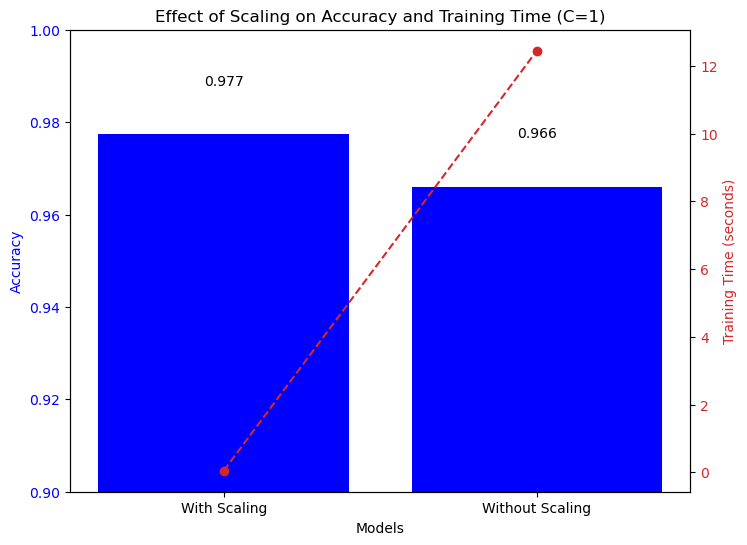

In [ ]:
model_with_scaling = SVC(kernel='linear', C=1)
model_without_scaling = SVC(kernel='linear', C=1)
models = [model_with_scaling, model_without_scaling]


data = [(X_train_scaled, X_test_scaled), (X_train, X_test)]


accuracies = []
individual_training_times = []
average_training_times = []


for model, (X_train_data, X_test_data) in zip(models, data):

    average_time = get_average_training_time(model, X_train_data, y_train)
    average_training_times.append(average_time)

    start_time = time.time()
    model.fit(X_train_data, y_train)
    individual_training_times.append(time.time() - start_time)


    accuracy = model.score(X_test_data, y_test)
    accuracies.append(accuracy)


fig, ax1 = plt.subplots(figsize=(8, 6))


color = 'tab:red'
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy', color='blue')
ax1.bar(['With Scaling', 'Without Scaling'], accuracies, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0.9, 1)

for i, acc in enumerate(accuracies):
    ax1.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', color='black')


ax2 = ax1.twinx()


color = 'tab:red'
ax2.set_ylabel('Training Time (seconds)', color=color)
ax2.plot(['With Scaling', 'Without Scaling'], individual_training_times, marker='o', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.title('Effect of Scaling on Accuracy and Training Time (C=1)')
plt.show()



*with scaling*

*Linear Kernel*

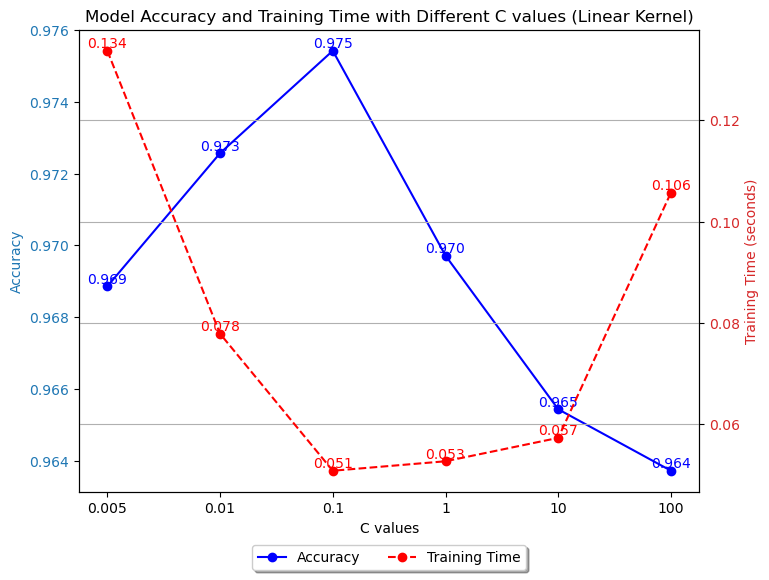

In [ ]:
c_values = [0.005, 0.01, 0.1, 1, 10, 100]
c_names = ['0.005', '0.01', '0.1', '1', '10', '100']


accuracies = []
training_times = []


for c in c_values:

    SVM_linear = SVC(kernel="linear", C=c)


    avg_training_time = get_average_training_time(SVM_linear, X_train_scaled, y_train)
    training_times.append(avg_training_time)


    scores = cross_val_score(SVM_linear, X_train_scaled, y_train, cv=10)
    avg_score = np.mean(scores)
    accuracies.append(avg_score)


fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:blue'
ax1.set_xlabel('C values')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(c_names, accuracies, marker='o', color='blue', label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(c_names, training_times, marker='o', linestyle='--', color='red', label='Training Time')
ax2.set_ylabel('Training Time (seconds)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
plt.xticks(np.arange(len(c_names)), c_names)

for i, txt in enumerate(accuracies):
    ax1.text(i, txt, f'{txt:.3f}', ha='center', va='bottom', color='blue')

for i, txt in enumerate(training_times):
    ax2.text(i, txt, f'{txt:.3f}', ha='center', va='bottom', color='red')

plt.title('Model Accuracy and Training Time with Different C values (Linear Kernel)')
plt.grid(True)

plt.show()
plt.show()


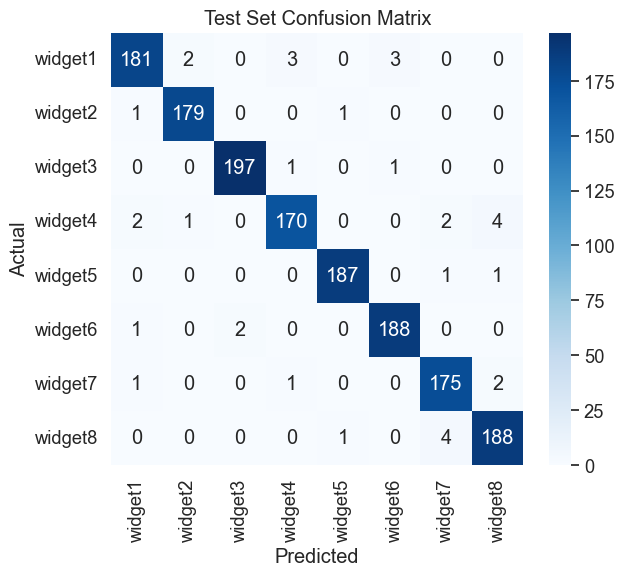


Classification Report:
              precision    recall  f1-score   support

     widget1       0.97      0.96      0.97       189
     widget2       0.98      0.99      0.99       181
     widget3       0.99      0.99      0.99       199
     widget4       0.97      0.95      0.96       179
     widget5       0.99      0.99      0.99       189
     widget6       0.98      0.98      0.98       191
     widget7       0.96      0.98      0.97       179
     widget8       0.96      0.97      0.97       193

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [ ]:
best_model = SVC(kernel='linear', C=0.1)
best_model.fit(X_train_scaled, y_train)


pred_te = best_model.predict(X_test_scaled)


conf_matrix_test = confusion_matrix(y_test, pred_te)


labels = sorted(y_train.unique())
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


class_report = classification_report(y_test, pred_te)
print("\nClassification Report:")
print(class_report)

*Polynomial Kernel*

In [ ]:
param_grid = {'C': [0.005, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}

SVM_poly = SVC(kernel='poly')

grid = GridSearchCV(estimator=SVM_poly, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)

grid.fit(X_train_scaled, y_train)

best_params = grid.best_params_

average_training_time = get_average_training_time(SVC(kernel='poly', **best_params), X_train_scaled, y_train)

print("Best parameters:", best_params)
print("Best cross-validation score:", grid.best_score_)
print("Average training time:", average_training_time)



Best parameters: {'C': 0.1, 'gamma': 0.1}
Best cross-validation score: 0.964857142857143
Average training time: 0.19099984169006348


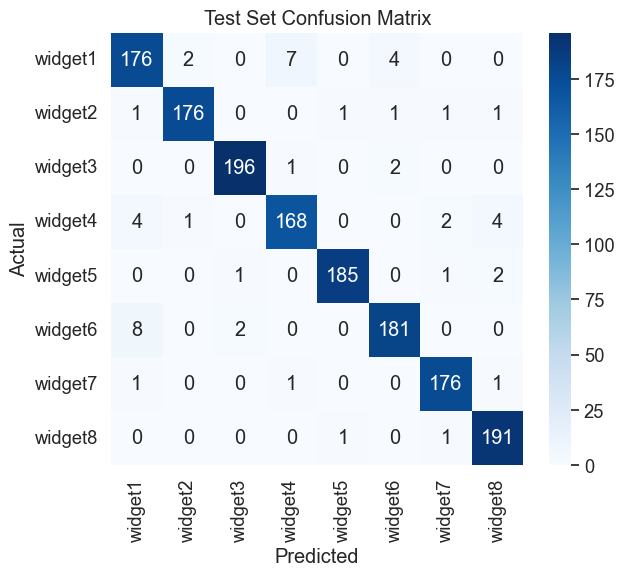


Classification Report:
              precision    recall  f1-score   support

     widget1       0.93      0.93      0.93       189
     widget2       0.98      0.97      0.98       181
     widget3       0.98      0.98      0.98       199
     widget4       0.95      0.94      0.94       179
     widget5       0.99      0.98      0.98       189
     widget6       0.96      0.95      0.96       191
     widget7       0.97      0.98      0.98       179
     widget8       0.96      0.99      0.97       193

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



In [ ]:
best_model_poly = SVC(kernel='poly', C=0.1, gamma=0.1)
best_model_poly.fit(X_train_scaled, y_train)

pred_te = best_model_poly.predict(X_test_scaled)


conf_matrix_test = confusion_matrix(y_test, pred_te)


labels = sorted(y_train.unique())
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


class_report = classification_report(y_test, pred_te)
print("\nClassification Report:")
print(class_report)

In [ ]:
param_grid = {'C': [0.005, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}

best_accuracy = 0
best_params = {}
average_training_times = []

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        svm = SVC(kernel='poly', C=C, gamma=gamma)

        scores = cross_val_score(svm, X_train_scaled, y_train, cv=10, scoring='accuracy')
        avg_score = np.mean(scores)


        training_time = get_average_training_time(svm, X_train_scaled, y_train)
        average_training_times.append(training_time)


        print(f"C={C}, gamma={gamma} - Accuracy: {avg_score}, Training Time: {training_time}")


        if avg_score > best_accuracy:
            best_accuracy = avg_score
            best_params = {'C': C, 'gamma': gamma}


print("Best parameters:", best_params)
print("Best cross-validation score:", best_accuracy)
print("Average training times:", average_training_times)

C=0.005, gamma=0.0001 - Accuracy: 0.12628571428571428, Training Time: 1.2712998867034913
C=0.005, gamma=0.001 - Accuracy: 0.12628571428571428, Training Time: 0.7065445899963378
C=0.005, gamma=0.005 - Accuracy: 0.12628571428571428, Training Time: 0.7008665800094604
C=0.005, gamma=0.1 - Accuracy: 0.8834285714285715, Training Time: 0.43716504573822024
C=0.005, gamma=1 - Accuracy: 0.9548571428571428, Training Time: 0.129074764251709
C=0.005, gamma=3 - Accuracy: 0.9508571428571428, Training Time: 0.13332972526550294
C=0.005, gamma=5 - Accuracy: 0.9508571428571428, Training Time: 0.12419362068176269
C=0.01, gamma=0.0001 - Accuracy: 0.12628571428571428, Training Time: 0.7052480220794678
C=0.01, gamma=0.001 - Accuracy: 0.12628571428571428, Training Time: 0.7071483850479126
C=0.01, gamma=0.005 - Accuracy: 0.12628571428571428, Training Time: 0.7181220293045044
C=0.01, gamma=0.1 - Accuracy: 0.9214285714285715, Training Time: 0.34612605571746824
C=0.01, gamma=1 - Accuracy: 0.9537142857142857, Trai

*RBF Kernel*

In [ ]:
param_grid = {'C': [0.005, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}

SVM_rbf = SVC(kernel='rbf')

grid = GridSearchCV(estimator=SVM_rbf, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)

grid.fit(X_train_scaled, y_train)

best_params = grid.best_params_

average_training_time = get_average_training_time(SVC(kernel='rbf', **best_params), X_train_scaled, y_train)

print("Best parameters:", best_params)
print("Best cross-validation score:", grid.best_score_)
print("Average training time:", average_training_time)


Best parameters: {'C': 10, 'gamma': 0.005}
Best cross-validation score: 0.9757142857142856
Average training time: 0.0914231300354004


In [ ]:
param_grid = {'C': [0.005, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}

best_accuracy = 0
best_params = {}
average_training_times = []

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        svm = SVC(kernel='rbf', C=C, gamma=gamma)

        scores = cross_val_score(svm, X_train_scaled, y_train, cv=10, scoring='accuracy')
        avg_score = np.mean(scores)


        training_time = get_average_training_time(svm, X_train_scaled, y_train)
        average_training_times.append(training_time)


        print(f"C={C}, gamma={gamma} - Accuracy: {avg_score}, Training Time: {training_time}")


        if avg_score > best_accuracy:
            best_accuracy = avg_score
            best_params = {'C': C, 'gamma': gamma}


print("Best parameters:", best_params)
print("Best cross-validation score:", best_accuracy)
print("Average training times:", average_training_times)

C=0.005, gamma=0.0001 - Accuracy: 0.1502857142857143, Training Time: 0.9277902603149414
C=0.005, gamma=0.001 - Accuracy: 0.15085714285714286, Training Time: 2.6509059190750124
C=0.005, gamma=0.005 - Accuracy: 0.15085714285714286, Training Time: 1.986765193939209
C=0.005, gamma=0.1 - Accuracy: 0.15085714285714286, Training Time: 1.9318919897079467
C=0.005, gamma=1 - Accuracy: 0.14514285714285716, Training Time: 1.4823630571365356
C=0.005, gamma=3 - Accuracy: 0.1285714285714286, Training Time: 0.8919145584106445
C=0.005, gamma=5 - Accuracy: 0.12685714285714286, Training Time: 0.9043351411819458
C=0.01, gamma=0.0001 - Accuracy: 0.1502857142857143, Training Time: 0.8603746175765992
C=0.01, gamma=0.001 - Accuracy: 0.15085714285714286, Training Time: 0.8492406606674194
C=0.01, gamma=0.005 - Accuracy: 0.15085714285714286, Training Time: 0.8491231203079224
C=0.01, gamma=0.1 - Accuracy: 0.5102857142857143, Training Time: 0.8369433164596558
C=0.01, gamma=1 - Accuracy: 0.14514285714285716, Traini

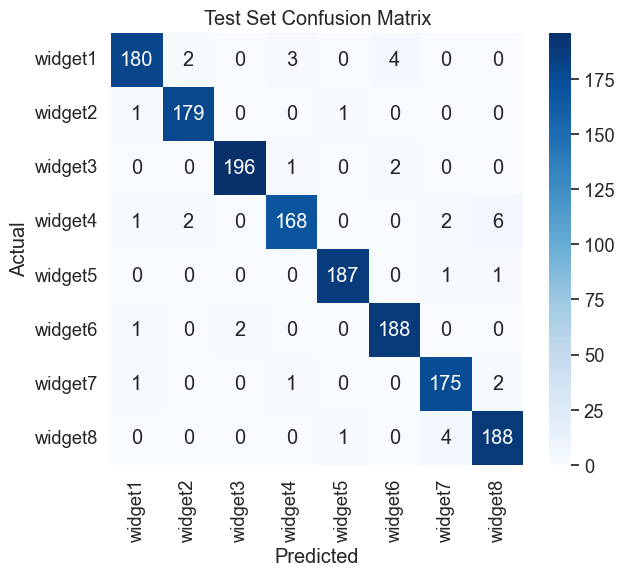


Classification Report:
              precision    recall  f1-score   support

     widget1       0.98      0.95      0.97       189
     widget2       0.98      0.99      0.98       181
     widget3       0.99      0.98      0.99       199
     widget4       0.97      0.94      0.95       179
     widget5       0.99      0.99      0.99       189
     widget6       0.97      0.98      0.98       191
     widget7       0.96      0.98      0.97       179
     widget8       0.95      0.97      0.96       193

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



In [ ]:
best_model_rbf = SVC(kernel='rbf', C=10, gamma=0.005)
best_model_rbf.fit(X_train_scaled, y_train)

pred_te = best_model_rbf.predict(X_test_scaled)


conf_matrix_test = confusion_matrix(y_test, pred_te)


labels = sorted(y_train.unique())
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


class_report = classification_report(y_test, pred_te)
print("\nClassification Report:")
print(class_report)

***Neural Networks***

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

In [8]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

*Learing Rate*

Training with LR=0.001 took 11.18 seconds
Training with LR=0.005 took 8.79 seconds
Training with LR=0.01 took 11.16 seconds
Training with LR=0.015 took 10.77 seconds


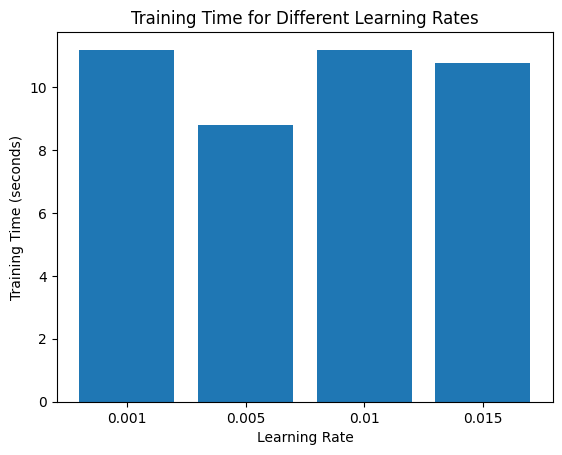

In [38]:
learning_rates = [0.001, 0.005, 0.01, 0.015]
epochs = 100

training_times = []

for lr in learning_rates:
    start_time = time.time()

    model = Sequential(name=f'Training-Model-LR-{lr}')
    input_shape = (data_points.shape[1],)
    model.add(Input(shape=input_shape))
    model.add(Dense(48, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=8, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x=X_train_scaled, y=y_train_encoded, validation_split=0.30, epochs=epochs, batch_size=128, verbose=0)

    end_time = time.time()
    elapsed_time = end_time - start_time
    training_times.append(elapsed_time)

    print(f"Training with LR={lr} took {elapsed_time:.2f} seconds")

# Plotting the training times for different learning rates
plt.bar([str(lr) for lr in learning_rates], training_times)
plt.xlabel('Learning Rate')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Different Learning Rates')
plt.show()

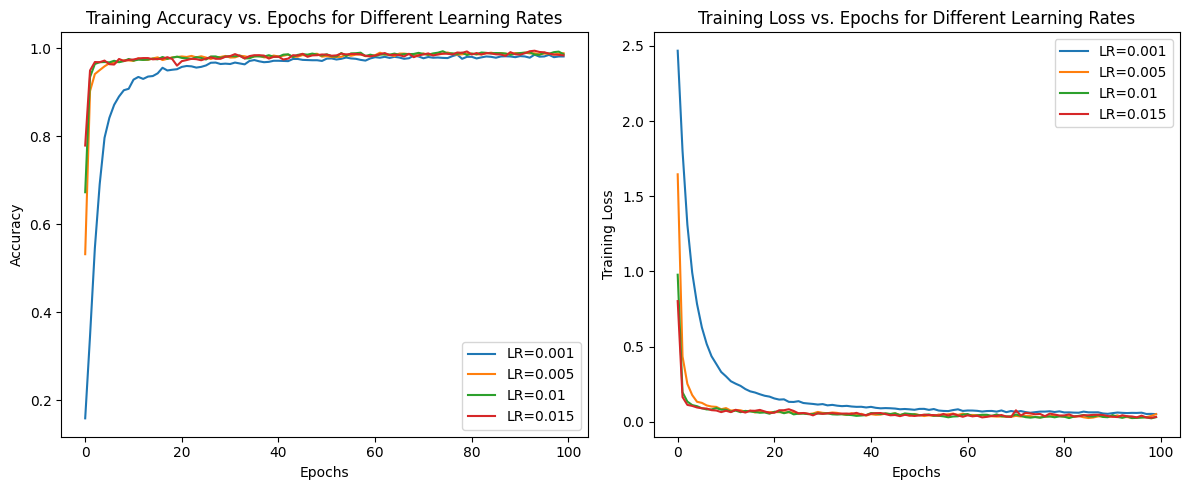

In [48]:
learning_rates = [0.001, 0.005, 0.01, 0.015]
epochs = 100

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
for lr in learning_rates:
    model = Sequential(name=f'Training-Model-LR-{lr}')
    model.add(Input(shape=input_shape))
    model.add(Dense(48, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=8, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x=X_train_scaled, y=y_train_encoded, validation_split=0.30, epochs=epochs, batch_size=128, verbose=0)

    plt.plot(history.history['accuracy'], label=f'LR={lr}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epochs for Different Learning Rates')
plt.legend()

plt.subplot(1, 2, 2)
for lr in learning_rates:
    model = Sequential(name=f'Training-Model-LR-{lr}')
    model.add(Input(shape=input_shape))
    model.add(Dense(48, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=8, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x=X_train_scaled, y=y_train_encoded, validation_split=0.30, epochs=epochs, batch_size=128, verbose=0)

    plt.plot(history.history['loss'], label=f'LR={lr}')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs for Different Learning Rates')
plt.legend()

plt.tight_layout()
plt.show()

*batch Sizes*

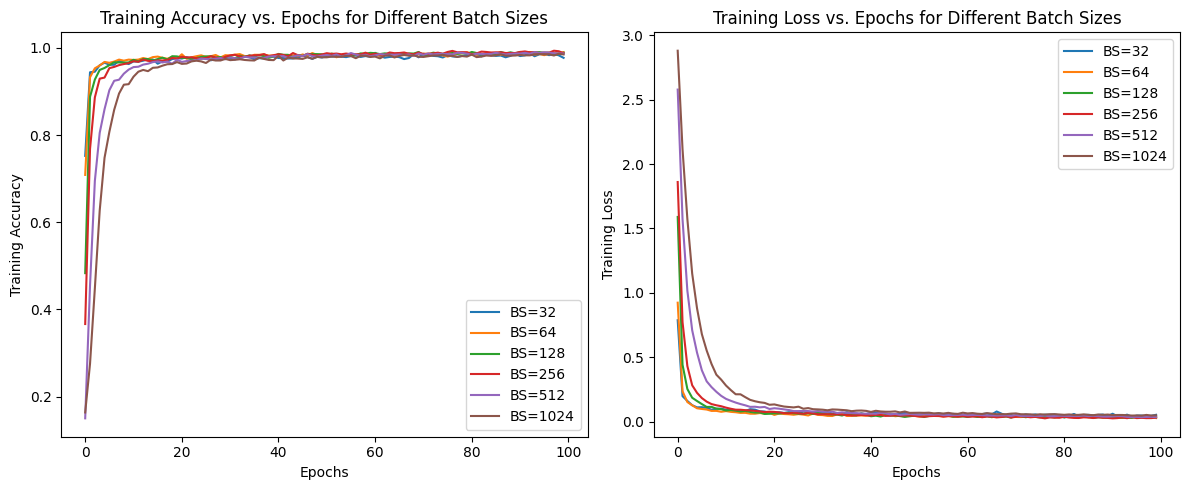

In [47]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
epochs = 100

plt.figure(figsize=(12, 5))

for batch_size in batch_sizes:
    model = Sequential(name=f'Training-Model-BS-{batch_size}')
    model.add(Input(shape=input_shape))
    model.add(Dense(48, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x=X_train_scaled, y=y_train_encoded, validation_split=0.30, epochs=epochs, batch_size=batch_size, verbose=0)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f'BS={batch_size}')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'BS={batch_size}')

plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Epochs for Different Batch Sizes')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs for Different Batch Sizes')
plt.legend()

plt.tight_layout()
plt.show()

Training with Batch Size=32 took 42.66 seconds
Training with Batch Size=64 took 21.42 seconds
Training with Batch Size=128 took 11.56 seconds
Training with Batch Size=256 took 8.20 seconds
Training with Batch Size=512 took 11.16 seconds
Training with Batch Size=1024 took 11.59 seconds


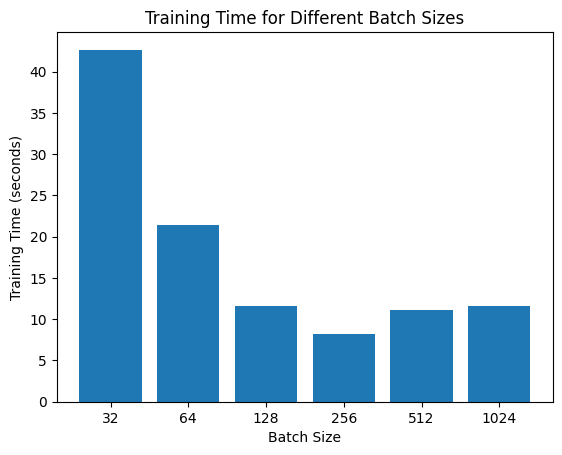

In [68]:
import time

batch_sizes = [32, 64, 128, 256, 512, 1024]
epochs = 100

training_times = []

for batch_size in batch_sizes:
    start_time = time.time()

    model = Sequential(name=f'Training-Model-BS-{batch_size}')
    model.add(Input(shape=input_shape))
    model.add(Dense(48, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x=X_train_scaled, y=y_train_encoded, validation_split=0.30, epochs=epochs, batch_size=batch_size, verbose=0)

    end_time = time.time()
    elapsed_time = end_time - start_time
    training_times.append(elapsed_time)

    print(f"Training with Batch Size={batch_size} took {elapsed_time:.2f} seconds")

# Plotting training times for different batch sizes
plt.bar([str(batch_size) for batch_size in batch_sizes], training_times)
plt.xlabel('Batch Size')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Different Batch Sizes')
plt.show()


*Number of layers and neurons*

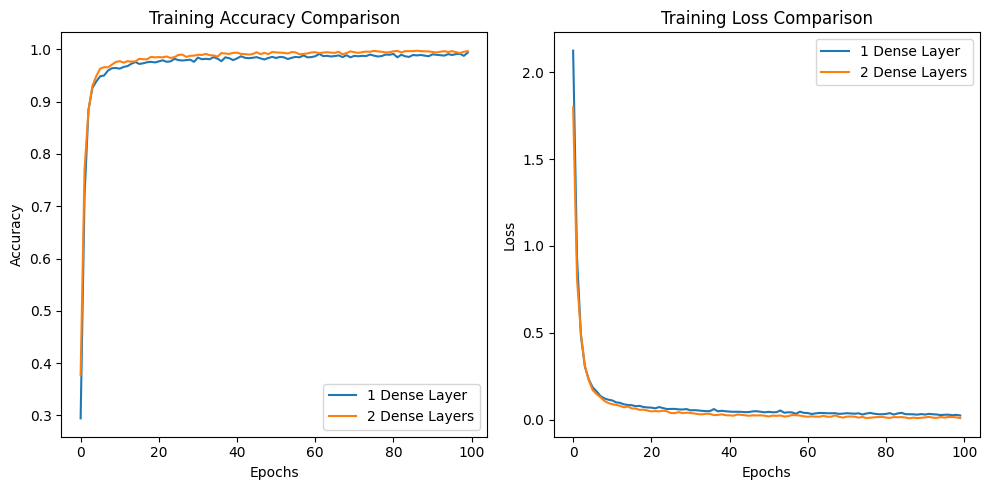

In [52]:
# Model 1 with 1 Dense layer
input_shape = (data_points.shape[1],)
model_1 = Sequential(name='Model-1')
model_1.add(Input(shape=input_shape))
model_1.add(Dense(48, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(rate=0.2))
model_1.add(Dense(8, activation='softmax'))
model_1.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(x=X_train_scaled, y=y_train_encoded, validation_split=0.30, epochs=100, batch_size=256, verbose=0)

# Model 2 with 2 Dense layers
input_shape = (data_points.shape[1],)
model_2 = Sequential(name='Model-2')
model_2.add(Input(shape=input_shape))
model_2.add(Dense(48, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dense(24, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(rate=0.2))
model_2.add(Dense(8, activation='softmax'))
model_2.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(x=X_train_scaled, y=y_train_encoded, validation_split=0.30, epochs=100, batch_size=256, verbose=0)

# Plotting accuracy comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='1 Dense Layer')
plt.plot(history_2.history['accuracy'], label='2 Dense Layers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()

# Plotting loss comparison
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='1 Dense Layer')
plt.plot(history_2.history['loss'], label='2 Dense Layers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()

plt.tight_layout()
plt.show()

*Dropout Ratio*

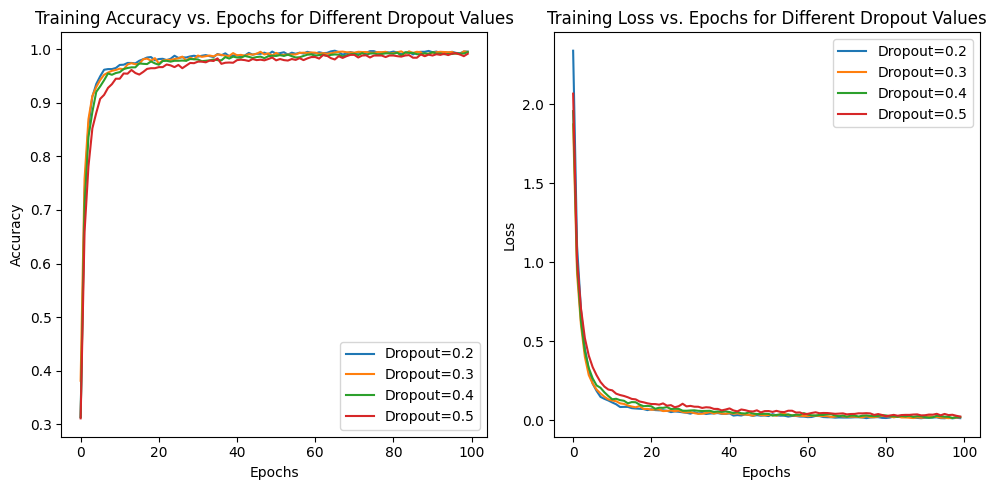

In [57]:
dropout_values = [0.2, 0.3, 0.4, 0.5]
epochs = 100

plt.figure(figsize=(10, 5))

# Plotting accuracy comparison
plt.subplot(1, 2, 1)
for dropout_rate in dropout_values:
    model = Sequential(name=f'Model-Dropout-{dropout_rate}')
    model.add(Input(shape=input_shape))
    model.add(Dense(48, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(24, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x=X_train_scaled, y=y_train_encoded, validation_split=0.30, epochs=epochs, batch_size=256, verbose=0)

    plt.plot(history.history['accuracy'], label=f'Dropout={dropout_rate}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epochs for Different Dropout Values')
plt.legend()

# Plotting loss comparison
plt.subplot(1, 2, 2)
for dropout_rate in dropout_values:
    model = Sequential(name=f'Model-Dropout-{dropout_rate}')
    model.add(Input(shape=input_shape))
    model.add(Dense(48, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(24, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x=X_train_scaled, y=y_train_encoded, validation_split=0.30, epochs=epochs, batch_size=256, verbose=0)

    plt.plot(history.history['loss'], label=f'Dropout={dropout_rate}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs for Different Dropout Values')
plt.legend()

plt.tight_layout()
plt.show()

Training with Dropout=0.2 took 26.32 seconds
Training with Dropout=0.3 took 9.11 seconds
Training with Dropout=0.4 took 8.36 seconds
Training with Dropout=0.5 took 16.61 seconds


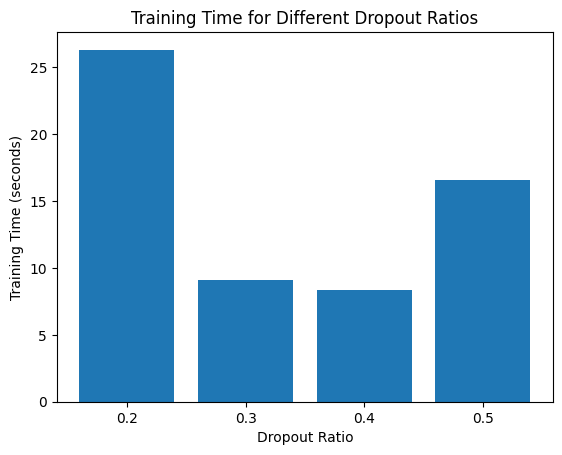

In [58]:
import time

dropout_values = [0.2, 0.3, 0.4, 0.5]
epochs = 100

training_times = []

for dropout_rate in dropout_values:
    start_time = time.time()

    model = Sequential(name=f'Model-Dropout-{dropout_rate}')
    model.add(Input(shape=input_shape))
    model.add(Dense(48, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(24, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x=X_train_scaled, y=y_train_encoded, validation_split=0.30, epochs=epochs, batch_size=256, verbose=0)

    end_time = time.time()
    elapsed_time = end_time - start_time
    training_times.append(elapsed_time)

    print(f"Training with Dropout={dropout_rate} took {elapsed_time:.2f} seconds")

# Plotting training times for different dropout ratios
plt.bar([str(dropout_rate) for dropout_rate in dropout_values], training_times)
plt.xlabel('Dropout Ratio')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Different Dropout Ratios')
plt.show()


***Final Model***

In [13]:
start_time = time.time()

In [14]:
input_shape = (data_points.shape[1],)
model = Sequential(name='Training-Model-8')
model.add(Input(shape=input_shape))
model.add(Dense(48, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(24, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Dense(8, activation='softmax'))
model.summary()

Model: "Training-Model-8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 batch_normalization_2 (Bat  (None, 48)                192       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 24)                1176      
                                                                 
 batch_normalization_3 (Bat  (None, 24)                96        
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_5 (Dense)             (None, 8)            

In [15]:
model.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train_scaled, y=y_train_encoded, validation_split=0.30, epochs=100, batch_size=256)


Epoch 1/100
10/10 [==============================] - 2s 54ms/step - loss: 2.0397 - accuracy: 0.3131 - val_loss: 1.6537 - val_accuracy: 0.5029
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0044 - accuracy: 0.6747 - val_loss: 1.2395 - val_accuracy: 0.7476
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6674 - accuracy: 0.8086 - val_loss: 0.8893 - val_accuracy: 0.8600
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4845 - accuracy: 0.8710 - val_loss: 0.6184 - val_accuracy: 0.9029
Epoch 5/100
10/10 [==============================] - 0s 11ms/step - loss: 0.3749 - accuracy: 0.9065 - val_loss: 0.4318 - val_accuracy: 0.9314
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2924 - accuracy: 0.9204 - val_loss: 0.3171 - val_accuracy: 0.9400
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2520 - accuracy: 0.9335 - val_loss: 0.2475 - val_accuracy: 0.9467
Epoch 

In [16]:
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

Training Time: 22.50 seconds


In [17]:
predictions = model.predict(X_test_scaled)

predictions = np.argmax(predictions, axis=1)


print('Predicted labels:',str(predictions))

print(classification_report(predictions, y_test_encoded))

47/47 [==============================] - 0s 2ms/step
Predicted labels: [1 5 7 ... 4 0 6]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       191
           1       0.98      0.97      0.97       183
           2       0.97      0.98      0.98       197
           3       0.93      0.94      0.94       177
           4       1.00      0.98      0.99       192
           5       0.97      0.96      0.96       193
           6       0.96      0.97      0.96       178
           7       0.95      0.97      0.96       189

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



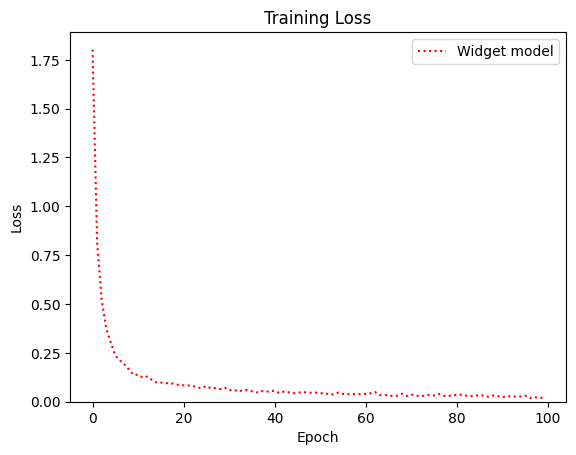

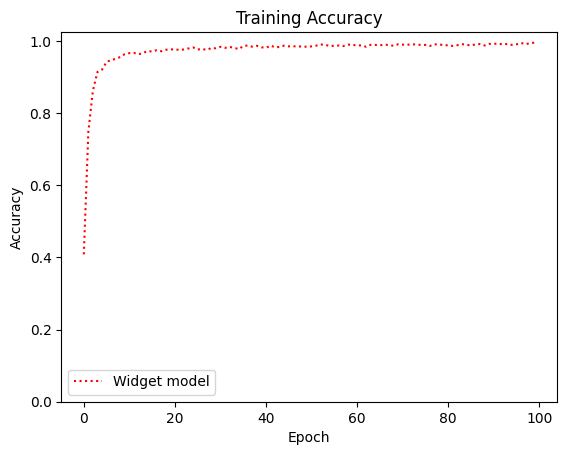

In [72]:
f, (ax1) = plt.subplots(1, 1)
ax1.plot(history.history['loss'],color='red',linestyle = 'dotted')
ax1.set(title='Training Loss',xlabel='Epoch',ylabel='Loss')
ax1.set_ylim(bottom=0)
ax1.legend(['Widget model'])
plt.show()

f, (ax1) = plt.subplots(1, 1)
ax1.plot(history.history['accuracy'],color='red',linestyle = 'dotted')
ax1.set(title='Training Accuracy',xlabel='Epoch',ylabel='Accuracy')
ax1.set_ylim(bottom=0)
ax1.legend(['Widget model'])
plt.show()